In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import mode
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from IPython.display import HTML
from pandas.io.formats.style import Styler
from functools import partial
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from matplotlib.ticker import FuncFormatter

plt.style.use('seaborn-notebook')

In [42]:
priceformatter = FuncFormatter(lambda x, pos: "${:.0f}".format(x))

def plot_dists_s2(data):
    fig, ax = plt.subplots(2, 3, figsize=(16, 10))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    
    titles = ["Manipulated Item:\nLow Variance", 
              "Manipulated Item:\nModerate Variance", 
              "Manipulated Item:\nHigh Variance"]
    # fmt: off
    dists = {
        "Manipulated": {
            "Low": [23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
                    26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28],
            "Med": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "High": [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                     26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
        },
        "Common": {
            "Low": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "Med": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "High": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                     26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],   
        }
    }
    # fmt: on
    xrange = np.arange(1, 50, 0.1)

    for i, disttype in enumerate(["Common", "Manipulated"]):
        for j, cond in enumerate(["Low", "Med", "High"]):
            # True dist
            tdist = dists[disttype][cond]
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, 25, sigma)
            ax[i][j].plot(xrange, z, **{"lw":2, "color":"black"})
            ## CI
            inflim = 25 - sigma*1.96
            suplim = 25 + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color="black")
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.sd_manipulated == cond) & (data.distname == disttype)]
            ## Distplot
            gb = pdists.groupby(["turkid"])
            f = partial(sns.distplot, hist=False, 
                        kde_kws={"lw":1, "color":colors[0], "bw":2, "alpha":0.2}, ax=ax[i][j])
            gb.value.apply(lambda x: f(x))

            # Aggregate dist
            ## Distplot
            st = gb.agg({"value":{"M":np.mean, "SD":np.std}}).mean()
            mu, sigma = st.value.M, st.value.SD
            ax[i][j].plot(xrange, stats.norm.pdf(xrange, loc=25, scale=sigma), 
                          **{"lw":3, "color":colors[1], "alpha":1, "zorder":100})
            ## CI    
            inflim = 25 - sigma*1.96
            suplim = 25 + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color=colors[1])
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color=colors[1])    

            # Cleaning
            ax[i][j].set_ylim(0, 0.4)
            ax[i][j].set_xlim(0, 51)
            sns.despine()
            ax[0][j].set_title(titles[j])
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter)
    
    # Legend
    ax[0][0].set_ylabel("Price Distributions for\n'Common' Item", size=12)
    ax[1][0].set_ylabel("Price Distributions for\n'Manipulated' Item", size=12)
    custom_lines = [Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
                    Line2D([0], [0], color=colors[1], lw=2),
                    Line2D([0], [0], color="black", lw=2),
                    Line2D([0], [0], color="white", lw=0),
                    Line2D([0], [0], color=colors[1], lw=2, ls=":"),
                    Line2D([0], [0], color="black", lw=2, ls=":"),
                   ]
    custom_labels = ['Individual Responses', 
                     'Gaussian Average Distribution (True Mean-Centered)', 
                     'True Distribution', "", "95% CI of Gaussian Average", 
                     "95% CI of True Distribution"]
    ax[1][1].legend(custom_lines, custom_labels, ncol=2, 
                   loc="lower center", bbox_to_anchor=(0.5, -0.4));
    


def plot_dists_s3(data):
    fig, ax = plt.subplots(2, 3, figsize=(16, 10))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    titles = ["Manipulated Item:\nLow Mean", 
              "Manipulated Item:\nModerate Mean", 
              "Manipulated Item:\nHigh Mean"]
    # fmt: off
    dists = {
        "Manipulated": {
            "Low": [6, 7, 9, 9, 10, 11, 12, 12, 13, 13, 14, 14, 15, 
                    16, 16, 17, 17, 18, 18, 19, 20, 21, 21, 23, 24],
            "Med": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "High": [26, 27, 29, 29, 30, 31, 32, 32, 33, 33, 34, 34, 
                     35, 36, 36, 37, 37, 38, 38, 39, 40, 41, 41, 43, 44],
        },
        "Common": {
            "Low": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "Med": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "High": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                     25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],   
        }
    }

    xrange = np.arange(1, 50, 0.1)
    for i, disttype in enumerate(["Common", "Manipulated"]):
        for j, cond in enumerate(["Low", "Med", "High"]):
            # True dist
            tdist = dists[disttype][cond]
            mu = np.array(tdist).mean()
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, mu, sigma)
            ax[i][j].plot(xrange, z, **{"lw":2, "color":"black"})
            ## Mean
            ax[i][j].axvline(mu, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.mean_manipulated == cond) & (data.distname == disttype)]
            ## Distplot
            gb = pdists.groupby(["turkid"])
            f = partial(sns.distplot, hist=False, 
                        kde_kws={"lw":1, "color":colors[0], "bw":2, "alpha":0.2}, ax=ax[i][j])
            gb.value.apply(lambda x: f(x))

            # Aggregate dist
            ## Distplot
            st = gb.agg({"value":{"M":np.mean, "SD":np.std}}).mean()
            mu, sigma = st.value.M, st.value.SD
            ax[i][j].plot(xrange, stats.norm.pdf(xrange, loc=mu, scale=sigma), 
                          **{"lw":3, "color":colors[1], "alpha":1, "zorder":100})
            ## CI    
            ax[i][j].axvline(mu, 0, 0.8, ls=":", color=colors[1])   

            # Cleaning
            ax[i][j].set_ylim(0, 0.25)
            ax[i][j].set_xlim(0, 51)
            sns.despine()
            ax[0][j].set_title(titles[j], size=12)
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter);

    ax[0][0].set_ylabel("Price Distributions for\n'Common' Item", size=12)
    ax[1][0].set_ylabel("Price Distributions for\n'Manipulated' Item", size=12)
    custom_lines = [Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
                    Line2D([0], [0], color=colors[1], lw=2),
                    Line2D([0], [0], color="black", lw=2),
                    Line2D([0], [0], color="white", lw=0),
                    Line2D([0], [0], color=colors[1], lw=2, ls=":"),
                    Line2D([0], [0], color="black", lw=2, ls=":"),
                   ]
    custom_labels = ['Reported Distributions', 
                     'Gaussian Average Distribution', 
                     'True Distribution', "", 
                     "Average Reported Mean", 
                     "Mean of True Distribution"]
    ax[1][1].legend(custom_lines,custom_labels, ncol=2, 
                   loc="lower center", bbox_to_anchor=(0.5, -0.4));
    
def plot_dists_fourcells(data, dists):
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    titles = ["Given Item: Low Var", "Given Item: High Var"]
    xrange = np.arange(1, 50, 0.1)

    for i, other in enumerate(["Low", "High"]):
        for j, focal in enumerate(["Low", "High"]):
            # True dist
            tdist = dists[focal]
            mu = np.array(tdist).mean()
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, mu, sigma)
            ax[i][j].plot(xrange, z, **{"lw":2, "color":"black"})
            ## CI
            inflim = 25 - sigma*1.96
            suplim = 25 + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color="black")
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.sd_focal == focal) & (data.sd_other == other)]
            ## Distplot
            gb = pdists.groupby(["turkid", "item"])
            f = partial(sns.distplot, hist=False, kde_kws={"lw":1, "color":colors[0], "bw":2, "alpha":0.2}, ax=ax[i][j])
            gb.value.apply(lambda x: f(x - x.mean() + 25))

            # Aggregate dist
            ## Distplot
            st = gb.agg({"value":{"M":np.mean, "SD":np.std}}).mean()
            mu, sigma = st.value.M, st.value.SD
            ax[i][j].plot(xrange, stats.norm.pdf(xrange, loc=25, scale=sigma), **{"lw":3, "color":colors[1], "alpha":1, "zorder":100})
            ## CI 
            inflim = 25 - sigma*1.96
            suplim = 25 + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color=colors[1])
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color=colors[1]) 

            # Cleaning
            ax[i][j].set_ylim(0, 0.25)
            ax[i][j].set_xlim(0, 51)

            sns.despine()
            ax[0][j].set_title(titles[j], size=12)
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter);

    ax[0][0].set_ylabel("Other Item: Low Var", size=12)
    ax[1][0].set_ylabel("Other Item: High Var", size=12)
    custom_lines = [Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
                    Line2D([0], [0], color=colors[1], lw=2),
                    Line2D([0], [0], color="black", lw=2),
                    Line2D([0], [0], color="white", lw=0),
                    Line2D([0], [0], color=colors[1], lw=2, ls=":"),
                    Line2D([0], [0], color="black", lw=2, ls=":"),
                   ]
    custom_labels = ['Reported Distributions (True Mean-Centered)', 
                     'Gaussian Average Distribution (True Mean-Centered)', 
                     'True Distribution', "", 
                     "95% CI of Gaussian Average", 
                     "95% CI of True Distribution"]
    ax[1][0].legend(custom_lines, custom_labels, ncol=2, 
                    loc="lower center", bbox_to_anchor=(1.2, -0.4));

# Supplementary Graphs

## Study 2

In [17]:
df2g = pd.read_csv("../Data/Study 2/LongData.csv")
df2g["distname"] = df2g.is_manipulated.apply(lambda x: "Manipulated" if x == True else "Common")
plot_dists_s2(df2g)

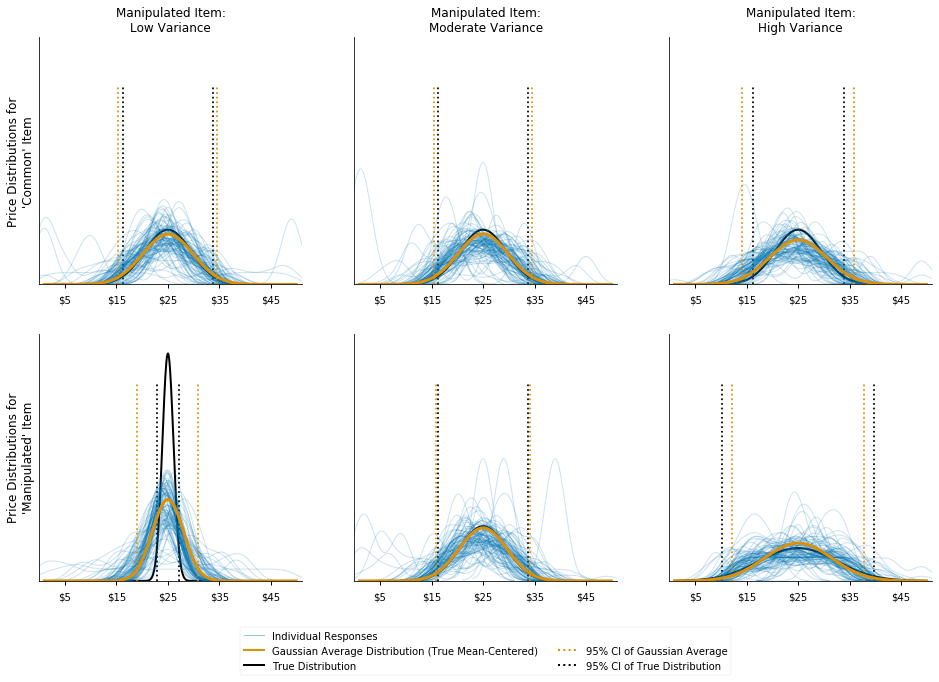

## Study 3

In [25]:
df3g = pd.read_csv("../Data/Study 3/LongData.csv")
df3g["distname"] = df3g.is_manipulated.apply(lambda x: "Manipulated" if x == True else "Common")

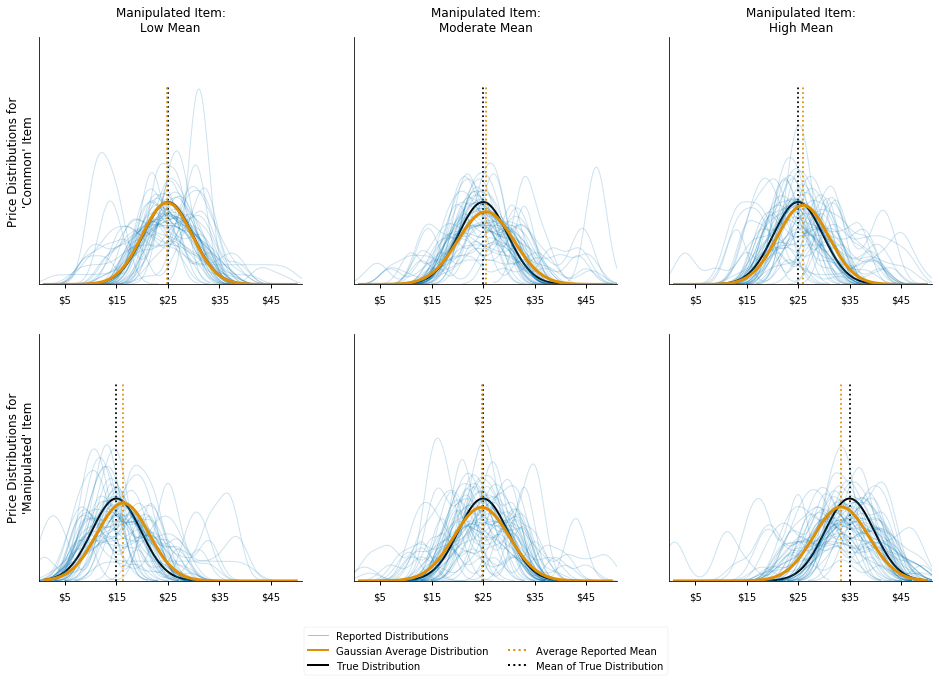

In [44]:
plot_dists_s3(df3g)

## Study 4

## Study 5

In [49]:
df5g = pd.read_csv("../Data/Study 5/LongData.csv")
df5g_sim = df5g.loc[df5g.similarity == "Similar"]
df5g_dissim = df5g.loc[df5g.similarity == "Dissimilar"]
dists_5 = {
    "Low": np.array([18.0, 19.0, 19.0, 20.0, 20.0, 21.0, 21.0, 21.0, 
                     22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0,
                     25.0, 25.0, 25.0, 26.0, 26.0, 27.0, 27.0, 28.0])+2,
    "High": np.array([10.0, 13.0, 15.0, 17.0, 18.0, 20.0, 21.0, 22.0, 
                      24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 
                      34.0, 35.0, 36.0, 38.0, 39.0, 41.0, 43.0, 46.0])-3
}

### Similar Items

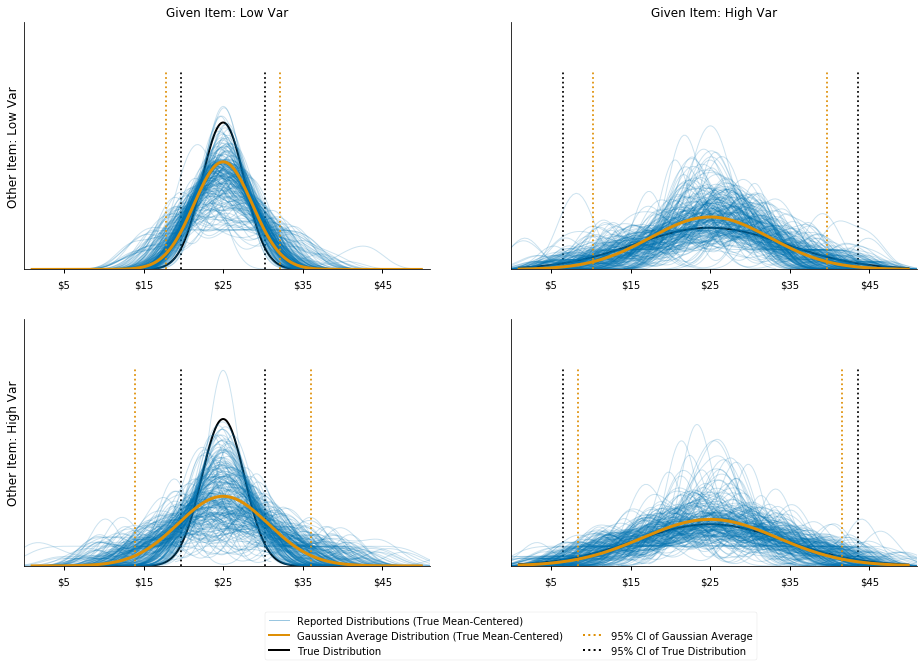

In [50]:
plot_dists_fourcells(df5g_sim, dists_5)

### Dissimilar Items

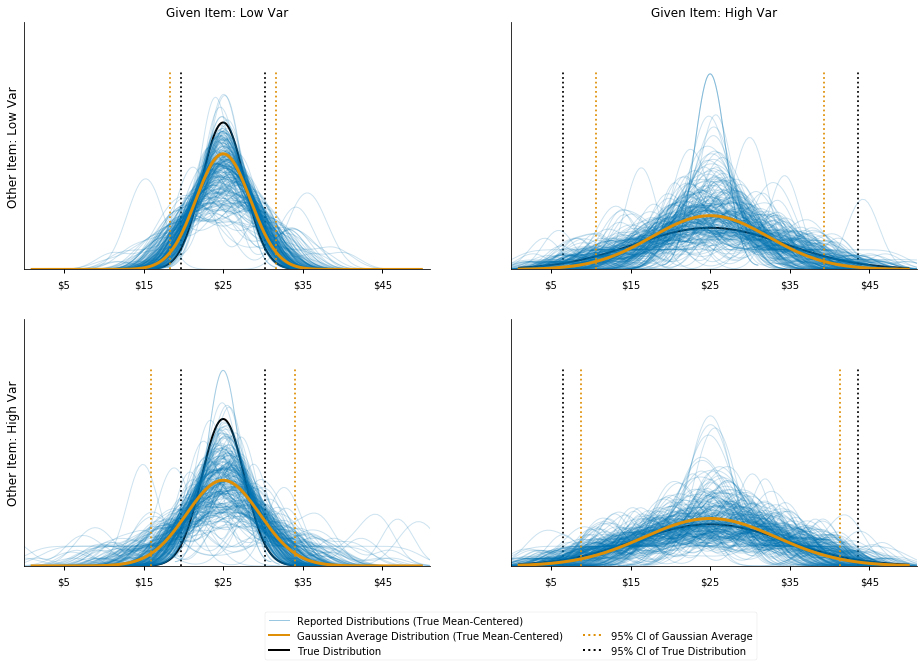

In [51]:
plot_dists_fourcells(df5g_dissim, dists_5)